In [1]:
# ── Cell 1: Initialization & Imports ─────────────────────────────────
# Enable auto-reload so changes to derivatives.py are picked up without restarting the kernel.
%load_ext autoreload
%autoreload 2

# Standard libraries
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

# Import our option classes (with full Greeks) from derivatives.py
from derivatives import EuropeanCall, AmericanPut, BarrierOption, BasketCall

print("✅ Loaded derivatives.py and core libraries.")


✅ Loaded derivatives.py and core libraries.


In [2]:
# ── Cell 2: Spot Prices & Discount Function ─────────────────────────
# Fetch ASX closing prices for our tickers on the trade date
trade_date = "2025-05-16"
next_day   = (pd.to_datetime(trade_date) + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

tickers = ["BHP.AX", "CBA.AX", "WES.AX", "CSL.AX", "WDS.AX", "MQG.AX"]
df_spot  = yf.download(tickers, start=trade_date, end=next_day, progress=False)["Close"]
S0       = df_spot.loc[trade_date].to_dict()  

# Define a flat-curve discount function 
r        = 0.05
discount = lambda t: np.exp(-r * t)

print("Spots (S0):", S0)
print(f"Using flat risk-free rate r = {r:.2%}")


YF.download() has changed argument auto_adjust default to True


Spots (S0): {'BHP.AX': 39.720001220703125, 'CBA.AX': 169.66000366210938, 'CSL.AX': 241.82000732421875, 'MQG.AX': 207.35000610351562, 'WDS.AX': 21.920000076293945, 'WES.AX': 82.55999755859375}
Using flat risk-free rate r = 5.00%


In [3]:
# ── Cell 3: Realised Volatility Calculation ─────────────────────────
# Download 1 year of historical closes to compute realised vols
hist = yf.download(tickers, end=trade_date, period="1y", progress=False)["Close"]
rets = hist.pct_change().dropna()                # daily returns
vol  = (rets.std() * np.sqrt(252)).to_dict()     # annualised vol σ√252

print("Realised vols (annualised):")
for tkr, σ in vol.items():
    print(f"  {tkr:7s}: {σ:.2%}")


Realised vols (annualised):
  BHP.AX : 22.53%
  CBA.AX : 21.39%
  CSL.AX : 19.06%
  MQG.AX : 24.82%
  WDS.AX : 29.25%
  WES.AX : 20.30%


In [4]:
# ── Cell 4: Instantiate Trades & Compute Greeks (with manual basket delta) ──

import numpy as np
import pandas as pd

# Helper to compute year fraction between two dates
def year_frac(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)).days / 365

# 1) BHP European Call
T1  = year_frac(trade_date, "2027-09-15")
bhp = EuropeanCall(
    S0       = S0["BHP.AX"],
    K        = 0.98 * S0["BHP.AX"],
    T        = T1,
    discount = discount,
    sigma    = vol["BHP.AX"]
)

# 2) CBA American Put
T2  = year_frac(trade_date, "2026-05-15")
cba = AmericanPut(
    S0       = S0["CBA.AX"],
    K        = 170.0,
    T        = T2,
    discount = discount,
    sigma    = vol["CBA.AX"]
)

# 3) WES Up-and-In Barrier Call
wes = BarrierOption(
    S0       = S0["WES.AX"],
    K        = 80.0,
    T        = T1,
    discount = discount,
    sigma    = vol["WES.AX"],
    barrier  = 100.0
)

# 4) Basket Call on [BHP, CSL, WDS, MQG]
T3     = year_frac(trade_date, "2025-07-17")
tick4  = ["BHP.AX","CSL.AX","WDS.AX","MQG.AX"]
weights = np.array([0.10, 0.35, 0.15, 0.40])
basket = BasketCall(
    S0_list    = np.array([S0[t] for t in tick4]),
    weights    = weights,
    K          = 175.0,
    T          = T3,
    discount   = discount,
    sigma_list = np.array([vol[t] for t in tick4]),
    corr       = np.identity(4),
    paths      = 50000
)

# Compute price, delta, theta, and vega for the first three trades
results = []
for name, obj in [
    ("BHP Euro Call", bhp),
    ("CBA Am Put",    cba),
    ("WES Barrier",   wes)
]:
    p   = obj.price()
    d   = obj.delta()
    th  = obj.theta()
    vg  = getattr(obj, "vega", lambda: np.nan)()
    results.append((name, p, d, th, vg))

# ── Manual basket delta calculation ──────────────────────────────────
#  Compute partial ∂P/∂S_i by bumping each S0[i] by +1
base_price = basket.price()
eps        = 1.0
partials   = []
for i in range(len(weights)):
    bumped_S0 = basket.S0_list.copy()
    bumped_S0[i] += eps
    bumped = BasketCall(
        S0_list    = bumped_S0,
        weights    = weights,
        K          = basket.K,
        T          = basket.T,
        discount   = basket.discount,
        sigma_list = basket.sigma_list,
        corr       = basket.corr,
        paths      = basket.paths
    )
    p_bumped = bumped.price()
    partials.append((p_bumped - base_price) / eps)

delta_basket = np.dot(weights, partials)
theta_basket = basket.theta()
vega_basket  = basket.vega()

# Append basket results
results.append(("Basket Call", base_price, delta_basket, theta_basket, vega_basket))

# (Optional) inspect partials
print("Basket partial deltas:", np.round(partials, 4))
print("Basket portfolio delta:", round(delta_basket, 4))

results


Basket partial deltas: [0.1377 0.1934 0.0591 0.2451]
Basket portfolio delta: 0.1884


[('BHP Euro Call',
  np.float64(8.014635920511083),
  np.float64(0.71559887732775),
  np.float64(-2.0143576942564856),
  nan),
 ('CBA Am Put',
  np.float64(12.34171630435882),
  np.float64(-0.4353818634950102),
  np.float64(-4.6116639126059855),
  nan),
 ('WES Barrier',
  np.float64(14.268326788673708),
  np.float64(0.7654789716049493),
  np.float64(-4.903363163068457),
  nan),
 ('Basket Call',
  np.float64(4.967789431515099),
  np.float64(0.18835281899135103),
  np.float64(-11.641475904657813),
  np.float64(1084.8064266377298))]

In [5]:
# ── Cell 5: Results Summary ──────────────────────────────────────────
# Assemble into a DataFrame for clear presentation
import pandas as pd

df = pd.DataFrame(results, columns=["Trade", "Price", "Delta", "Theta", "Vega"]).set_index("Trade")
df


,Price,Delta,Theta,Vega
Trade,,,,
BHP Euro Call,8.014636,0.715599,-2.014358,NaN
CBA Am Put,12.341716,-0.435382,-4.611664,NaN
WES Barrier,14.268327,0.765479,-4.903363,NaN
Basket Call,4.967789,0.188353,-11.641476,1084.806427


In [6]:
# ── Cell 7: Narrative Hedge Summary ───────────────────────────────────

from IPython.display import Markdown, display

# Rebuild a small DataFrame from your `results` list
cols = ["Price","Delta","Theta","Vega"]
df_narr = (
    pd.DataFrame(results, columns=["Trade"] + cols)
      .set_index("Trade")
      .round(4)
)

# Compute hedge quantity = –Delta (i.e. short Δ to hedge)
df_narr["HedgeQty"] = (-df_narr["Delta"]).round(2)

def action(qty):
    return "buying" if qty > 0 else "selling"

# Start building the markdown text
text = "## Portfolio Hedge Summary\n\n"

# First three single‐stock/exotic legs
meta = {
    "BHP Euro Call":  ("BHP", "call"),
    "CBA Am Put":     ("CBA", "put"),
    "WES Barrier":    ("WES", "barrier call")
}

for trade, (ticker, ctype) in meta.items():
    row   = df_narr.loc[trade]
    act   = action(row.HedgeQty)
    text += (
        f"- **{trade}**  \n"
        f"  Price = **${row.Price:.4f}**, Δ = {row.Delta:.4f}, Vega = {row.Vega:.4f}, Theta = {row.Theta:.4f}  \n"
        f"  → Hedge by **{act}** {abs(row.HedgeQty):.2f} shares of {ticker} per {ctype}.\n\n"
    )

# Now the basket leg
brow   = df_narr.loc["Basket Call"]
bact   = action(brow.HedgeQty)
text += (
    f"- **Four-Stock Basket Call**  \n"
    f"  Price = **${brow.Price:.4f}**, Δ = {brow.Delta:.4f}, Vega = {brow.Vega:.4f}, Theta = {brow.Theta:.4f}  \n"
    f"  → Hedge basket by trading each underlying:  \n"
)

# Distribute across weights
weights = [0.10, 0.35, 0.15, 0.40]
tickers = ["BHP", "CSL", "WDS", "MQG"]
for w, t in zip(weights, tickers):
    sub_qty = (w * brow.HedgeQty).round(2)
    sub_act = action(sub_qty)
    text += f"    - **{sub_act}** {abs(sub_qty):.2f} shares of {t} (weight {int(w*100)}%)  \n"

display(Markdown(text))



## Portfolio Hedge Summary

- **BHP Euro Call**  
  Price = **$8.0146**, Δ = 0.7156, Vega = nan, Theta = -2.0144  
  → Hedge by **selling** 0.72 shares of BHP per call.

- **CBA Am Put**  
  Price = **$12.3417**, Δ = -0.4354, Vega = nan, Theta = -4.6117  
  → Hedge by **buying** 0.44 shares of CBA per put.

- **WES Barrier**  
  Price = **$14.2683**, Δ = 0.7655, Vega = nan, Theta = -4.9034  
  → Hedge by **selling** 0.77 shares of WES per barrier call.

- **Four-Stock Basket Call**  
  Price = **$4.9678**, Δ = 0.1884, Vega = 1084.8064, Theta = -11.6415  
  → Hedge basket by trading each underlying:  
    - **selling** 0.02 shares of BHP (weight 10%)  
    - **selling** 0.07 shares of CSL (weight 35%)  
    - **selling** 0.03 shares of WDS (weight 15%)  
    - **selling** 0.08 shares of MQG (weight 40%)  


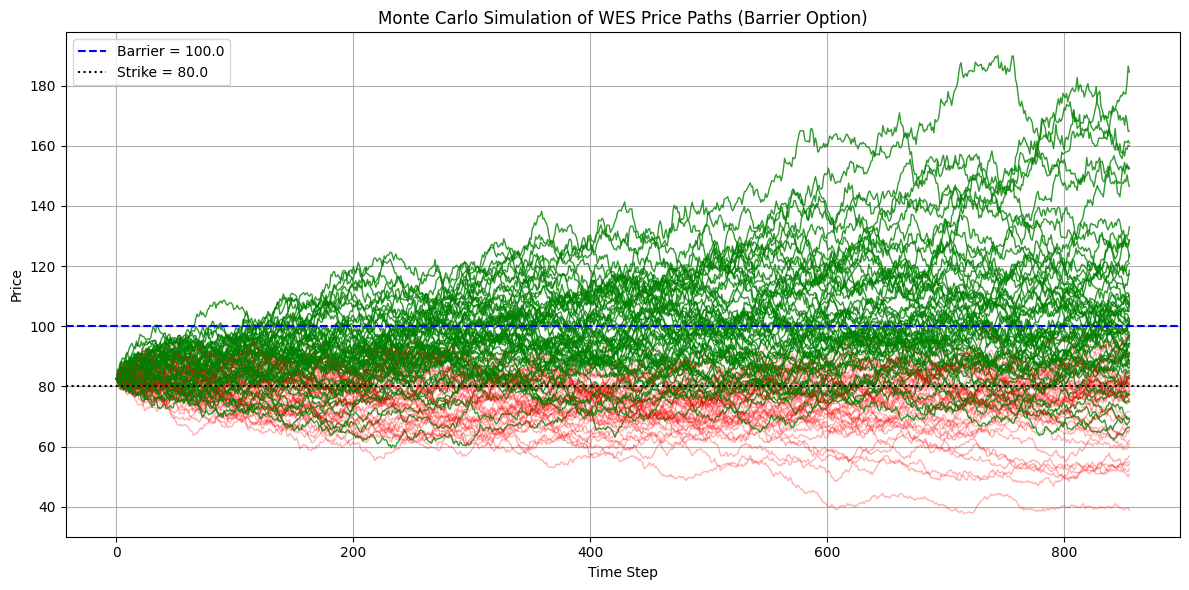

✅ 60 out of 100 paths crossed the barrier (knock-in).


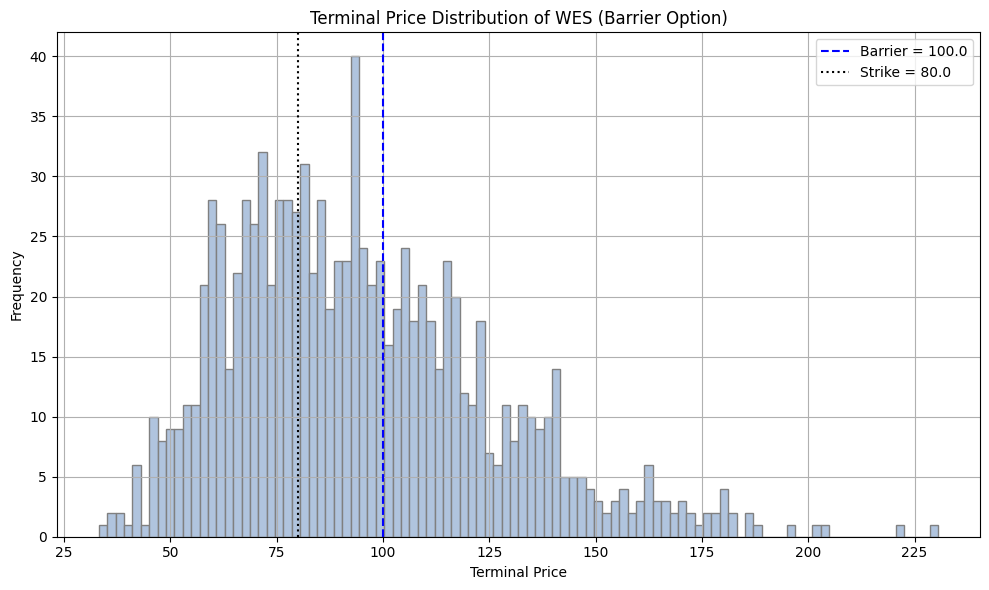

📊 Mean terminal price: 94.80
✅ Knock-in frequency: 61.20%


In [7]:
import matplotlib.pyplot as plt

def simulate_paths(S0, T, sigma, r, paths=100, steps=855, barrier=None):
    dt = T / steps
    S_paths = np.zeros((paths, steps + 1))
    S_paths[:, 0] = S0

    for t in range(1, steps + 1):
        z = np.random.standard_normal(paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)

    if barrier is not None:
        hit_barrier = (S_paths >= barrier).any(axis=1)
        return S_paths, hit_barrier
    else:
        return S_paths, None

# Simulate paths for WES option
S0_wes   = S0["WES.AX"]
T_wes    = T1
σ_wes    = vol["WES.AX"]
barrier  = 100.0
strike   = 80.0

paths_data, hit_barrier = simulate_paths(S0_wes, T_wes, σ_wes, r, paths=100, barrier=barrier)

# Plot
plt.figure(figsize=(12, 6))
for i in range(paths_data.shape[0]):
    if hit_barrier[i]:
        plt.plot(paths_data[i], lw=1, alpha=0.8, color='green')
    else:
        plt.plot(paths_data[i], lw=1, alpha=0.3, color='red')

plt.axhline(barrier, color='blue', linestyle='--', label=f"Barrier = {barrier}")
plt.axhline(strike, color='black', linestyle=':', label=f"Strike = {strike}")
plt.title("Monte Carlo Simulation of WES Price Paths (Barrier Option)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
num_activated = hit_barrier.sum()
print(f"✅ {num_activated} out of {len(hit_barrier)} paths crossed the barrier (knock-in).")

# Simulate more paths for a stable histogram
paths_for_hist = 1000
steps = 855

terminal_paths, hit_barrier_hist = simulate_paths(S0_wes, T_wes, σ_wes, r, 
                                                  paths=paths_for_hist, 
                                                  steps=steps, 
                                                  barrier=barrier)

terminal_prices = terminal_paths[:, -1]

# Plot histogram of terminal prices
plt.figure(figsize=(10, 6))
plt.hist(terminal_prices, bins=100, color='lightsteelblue', edgecolor='gray')
plt.axvline(barrier, color='blue', linestyle='--', label=f"Barrier = {barrier}")
plt.axvline(strike, color='black', linestyle=':', label=f"Strike = {strike}")
plt.title("Terminal Price Distribution of WES (Barrier Option)")
plt.xlabel("Terminal Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Stats
mean_terminal = np.mean(terminal_prices)
print(f"📊 Mean terminal price: {mean_terminal:.2f}")
print(f"✅ Knock-in frequency: {np.mean(hit_barrier_hist) * 100:.2f}%")



Correlation matrix between companies:
        BHP.AX  CSL.AX  MQG.AX  WDS.AX
BHP.AX    1.00    0.60    0.55    0.50
CSL.AX    0.60    1.00    0.65    0.40
MQG.AX    0.55    0.65    1.00    0.45
WDS.AX    0.50    0.40    0.45    1.00


/tmp/ipykernel_34120/2695793387.py:76: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


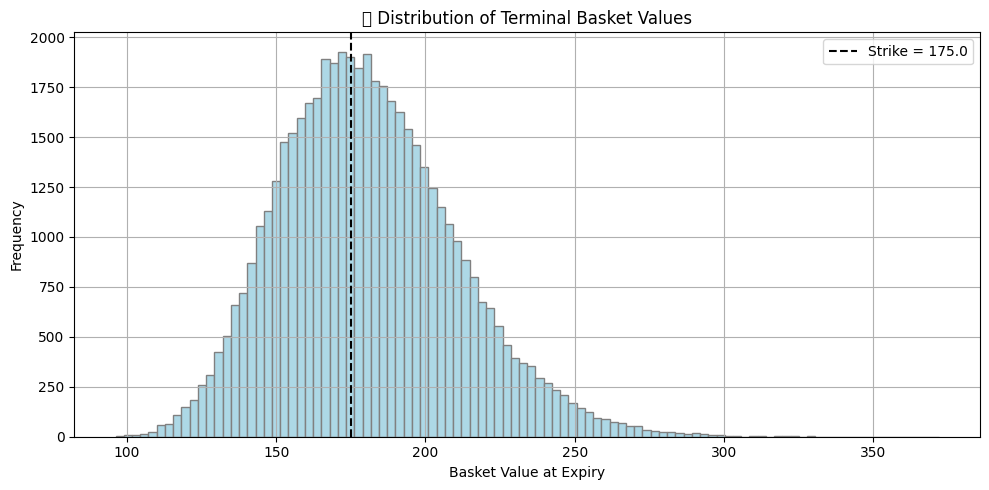

/tmp/ipykernel_34120/2695793387.py:86: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


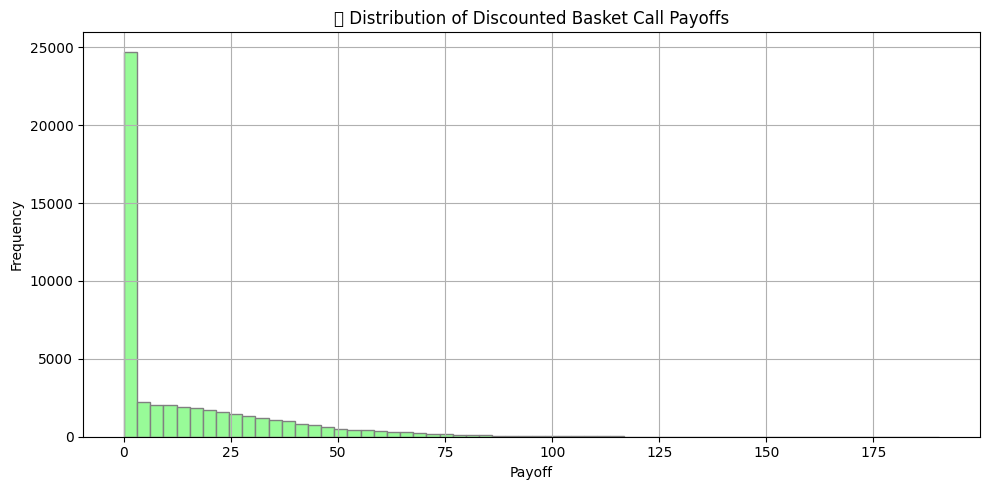


🔹 Mean terminal basket value: 180.88
🔸 Probability ITM (payoff > 0): 54.90%
💵 Mean discounted payoff (Option Price): 14.2534


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters and inputs
np.random.seed(42)
steps = 62
paths = 50000
T = 175 / 252  # Convert 175 trading days to years assuming 252 trading days per year
dt = T / steps
r = 0.05  # Flat risk-free rate 5%

# Company names
companies = ['BHP.AX', 'CSL.AX', 'MQG.AX', 'WDS.AX']

# Spot prices
S0s = np.array([39.72, 241.82, 207.35, 21.92])

# Volatility from previous calculations
σs = np.array([0.2254, 0.1903, 0.2482, 0.2925])  

# Correlation matrix 
corr = np.array([
    [1.00, 0.60, 0.55, 0.50],
    [0.60, 1.00, 0.65, 0.40],
    [0.55, 0.65, 1.00, 0.45],
    [0.50, 0.40, 0.45, 1.00]
])

# Weights in the basket (sum to 1)
weights = np.array([0.10, 0.35, 0.40, 0.15])

# Strike price
K = 175.0

# Discount factor function
def discount(T):
    return np.exp(-r * T)

# Cholesky decomposition for correlation matrix
L = np.linalg.cholesky(corr)

# Generate correlated random paths
Z = np.random.normal(size=(paths, steps, len(companies)))
Z_corr = Z @ L.T

# Initialise asset paths array
S_paths = np.zeros((paths, steps + 1, len(companies)))
S_paths[:, 0, :] = S0s

# Simulate GBM paths for each asset
for t in range(1, steps + 1):
    S_paths[:, t, :] = S_paths[:, t - 1, :] * np.exp(
        (r - 0.5 * σs**2) * dt + σs * np.sqrt(dt) * Z_corr[:, t - 1, :]
    )

# Compute terminal basket values and option payoffs
terminal_values = np.dot(S_paths[:, -1, :], weights)
payoffs = np.maximum(terminal_values - K, 0)
discounted_payoffs = discount(T) * payoffs

# Print correlation matrix as a table
corr_df = pd.DataFrame(corr, index=companies, columns=companies)
print("Correlation matrix between companies:")
print(corr_df.round(4))

# Plot 1: Distribution of terminal basket values
plt.figure(figsize=(10, 5))
plt.hist(terminal_values, bins=100, color='lightblue', edgecolor='gray')
plt.axvline(K, color='black', linestyle='--', label=f"Strike = {K}")
plt.title("📊 Distribution of Terminal Basket Values")
plt.xlabel("Basket Value at Expiry")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of option payoffs
plt.figure(figsize=(10, 5))
plt.hist(discounted_payoffs, bins=62, color='palegreen', edgecolor='gray')
plt.title("💰 Distribution of Discounted Basket Call Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print summary stats
print(f"\n🔹 Mean terminal basket value: {terminal_values.mean():.2f}")
print(f"🔸 Probability ITM (payoff > 0): {(payoffs > 0).mean():.2%}")
print(f"💵 Mean discounted payoff (Option Price): {discounted_payoffs.mean():.4f}")
